In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.integrate
import scipy.stats as stats
from scipy.interpolate import interp1d

In [2]:
pd.set_option('display.min_rows', 100)

**Problem 1**

Based on Table in above Scenario, estimate the expected win rate for a bid repsonse at a given price (prices are listed in table). State your assumptions clearly and provide the steps on how you arrived at your answer.

**Problem 2**

We receive money from our advertisers if we deliver them a win. Lets say that our advertiser is willing to pay $0.50 per win. This then becomes the upper bound for the bid valuation that we can submit in response to the publisher. For example, if we submit a bid response of $0.40 and we win, then the advertiser pays us $0.50, we pay $0.40 to the publisher and we made a net revenue of $0.10 .

If our goal was to maximize net revenue, what is the most optimal bid valuation we should send in our response? Use your estimations from Problem1 and all other available information.

Here is the json for Table 1 if you want to play around with it.

In [3]:
table = [{"app": "A", "bid_price": 0.01, "win": 0, "events": 100000}, 
{"app": "A", "bid_price": 0.01, "win": 1, "events": 0}, 
{"app": "A", "bid_price": 0.1, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.1, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 0.2, "win": 0, "events": 8000000}, 
{"app": "A", "bid_price": 0.2, "win": 1, "events": 2000000}, 
{"app": "A", "bid_price": 0.4, "win": 0, "events": 700000}, 
{"app": "A", "bid_price": 0.4, "win": 1, "events": 300000}, 
{"app": "A", "bid_price": 0.5, "win": 0, "events": 80000}, 
{"app": "A", "bid_price": 0.5, "win": 1, "events": 20000}, 
{"app": "A", "bid_price": 0.75, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.75, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 1, "win": 0, "events": 400}, 
{"app": "A", "bid_price": 1, "win": 1, "events": 600}, 
{"app": "A", "bid_price": 2, "win": 0, "events": 30}, 
{"app": "A", "bid_price": 2, "win": 1, "events": 70}, 
{"app": "A", "bid_price": 5, "win": 0, "events": 2}, 
{"app": "A", "bid_price": 5, "win": 1, "events": 8}, 
{"app": "A", "bid_price": 9, "win": 0, "events": 0}, 
{"app": "A", "bid_price": 9, "win": 1, "events": 1}
]

In [4]:
df = pd.DataFrame(table)

## Part 1

In [5]:
df['total_events'] = np.cumsum(df['events'])
total_events_per_bid = pd.DataFrame(df.groupby('bid_price')['events'].sum()).reset_index() \
    .rename(columns={'events': 'total_events_per_bid', 'bid_price': 'bp'})
total_events_per_bid

,bp,total_events_per_bid
0,0.01,100000
1,0.10,10000
2,0.20,10000000
3,0.40,1000000
4,0.50,100000
5,0.75,10000
6,1.00,1000
7,2.00,100
8,5.00,10
9,9.00,1


In [6]:
df['total_win_prob'] = df.apply(lambda row: round(row.events/row.total_events, 3) if row.win==1 else 0, axis=1)
df['total_win_rate'] = df.apply(lambda row: round(row.events/row.total_events, 3) if row.win==0 else row.total_win_prob, axis=1)
df['total_odds'] = df['total_win_rate'].div(df.groupby('bid_price')['total_win_rate'].shift(1))

df = df.merge(total_events_per_bid, left_on='bid_price', right_on='bp').drop(['bp'], axis=1)
df['win_prob'] = df.apply(lambda row: round(row.events/row.total_events_per_bid, 3) if row.win==1 else 0, axis=1)
df['win_rate'] = df.apply(lambda row: round(row.events/row.total_events_per_bid, 3) if row.win_prob==0 else row.win_prob, axis=1)
df['odds'] = df['win_rate'].div(df.groupby('bid_price')['win_rate'].shift(1))

df = df.fillna(0)
df = df.drop(['total_win_prob', 'win_prob'], axis=1)
df

,app,bid_price,win,events,total_events,total_win_rate,total_odds,total_events_per_bid,win_rate,odds
0,A,0.01,0,100000,100000,1.000,0.000000,100000,1.0,0.000000
1,A,0.01,1,0,100000,0.000,0.000000,100000,0.0,0.000000
2,A,0.10,0,7000,107000,0.065,0.000000,10000,0.7,0.000000
3,A,0.10,1,3000,110000,0.027,0.415385,10000,0.3,0.428571
4,A,0.20,0,8000000,8110000,0.986,0.000000,10000000,0.8,0.000000
5,A,0.20,1,2000000,10110000,0.198,0.200811,10000000,0.2,0.250000
6,A,0.40,0,700000,10810000,0.065,0.000000,1000000,0.7,0.000000
7,A,0.40,1,300000,11110000,0.027,0.415385,1000000,0.3,0.428571
8,A,0.50,0,80000,11190000,0.007,0.000000,100000,0.8,0.000000
9,A,0.50,1,20000,11210000,0.002,0.285714,100000,0.2,0.250000


### Observations

**1. Assumption - Bidding events are sequential for given bid prices**

1. If bidding events are sequential (i.e total events as cummultive sum of all previous events observed till the current bid price), and we observe losses given bid price for n events and then m wins for the same bid price, and then shift to next higher bid price. In this case, we should observe win rate w.r.t overall events that were recorded up until current bid price
2. In that case, bid prices $0.1 and $0.4 have the highest odds of 0.415, but in a bidding scenario higher bid has more chances of winning even with same win rate. Also, the number of wins corresponding to $0.4 is more than that for $0.1 from the given data which means we start losing auctions with $0.1 more early even with the same win rate.

**2. Assumption - Bidding events are independent for given bid prices**

1. If events are independent w.r.t to each bid price, then bidding should be done with bid price of highest win rate (4) i.e $5, ignoring $9 because only 1 event

These are obersved win rates and we thus using this we can calculate expectecd win rates using a number of methods.

<AxesSubplot:xlabel='bid_price'>

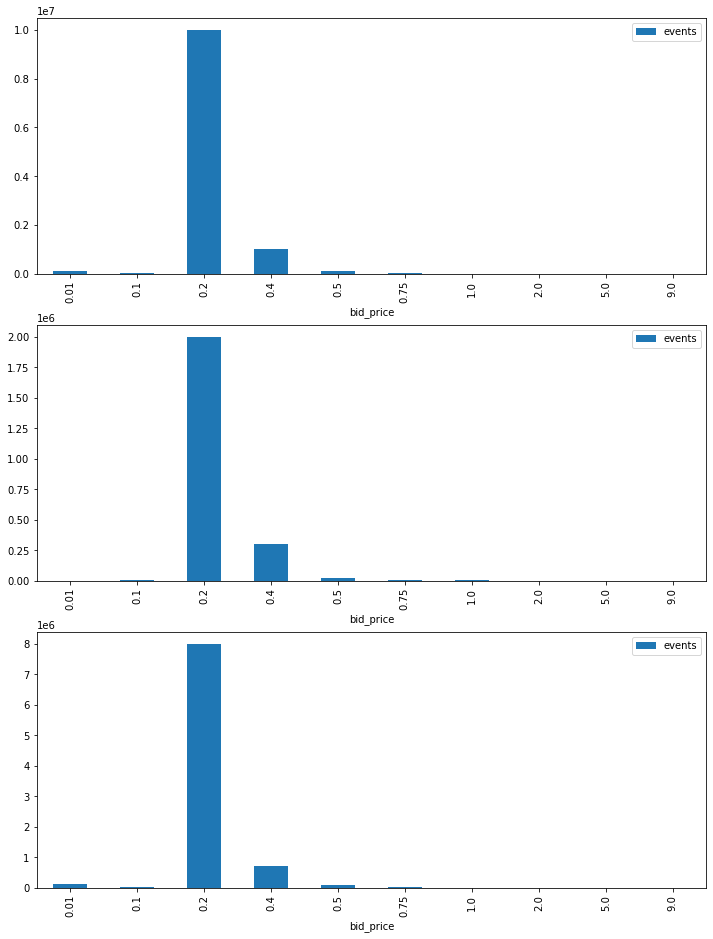

In [7]:
fig, axs = plt.subplots(3, figsize=(12, 16))
df.groupby('bid_price').sum('events').reset_index().plot.bar(ax=axs[0], x='bid_price', y='events')
df[df['win']==1].plot.bar(ax=axs[1], x='bid_price', y='events')
df[df['win']==0].plot.bar(ax=axs[2], x='bid_price', y='events')

<AxesSubplot:xlabel='bid_price'>

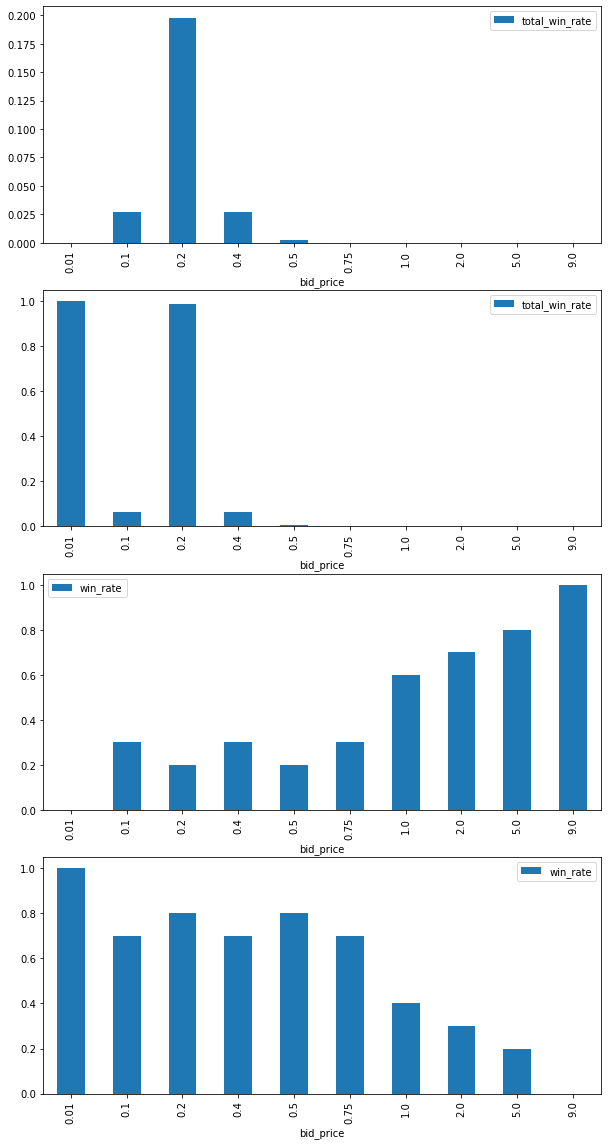

In [8]:
fig, axs = plt.subplots(4, figsize=(10, 20))
df[df['win']==1].plot.bar(ax=axs[0], x='bid_price', y='total_win_rate')
df[df['win']==0].plot.bar(ax=axs[1], x='bid_price', y='total_win_rate')
df[df['win']==1].plot.bar(ax=axs[2], x='bid_price', y='win_rate')
df[df['win']==0].plot.bar(ax=axs[3], x='bid_price', y='win_rate')

### 1. Observations

1. We can see that both events data and win rate follows a normal distribution w.r.t the bid prices in the given data.

2. Since the outcome of a bid event has only 2 option - Win or Lose. We can assume that win rate for a bid price follows a binomial distribution, which can be approximated by a normal distribution assumption.

#### 2. There can be several other methods that can be used to estimate win rates for each given bid price based on different assumptions.

1. Assuming **Normal distribution** of data, we can cumulative density function for each bid price from the distribution to get estimated win rates.

2. Using a **Beta-binomial model**, which combines prior distribution with the likelihood of wins to estimate posterior distribution.

3. Monte-Carlo simulation, Q-learning, Multi-armed bandits approachs - We can simulate an environment based on given historical data to estimate which bid price has a higher reward / win rate estimation.

In [9]:
df_summary = df.groupby('bid_price').agg({'events': 'sum'}).reset_index()
df_summary['win'] = df[df['win']==1]['events'].tolist()
df_summary["win_rate"] = df_summary["win"] / df_summary["events"]
df_summary

,bid_price,events,win,win_rate
0,0.01,100000,0,0.0
1,0.10,10000,3000,0.3
2,0.20,10000000,2000000,0.2
3,0.40,1000000,300000,0.3
4,0.50,100000,20000,0.2
5,0.75,10000,3000,0.3
6,1.00,1000,600,0.6
7,2.00,100,70,0.7
8,5.00,10,8,0.8
9,9.00,1,1,1.0


In [10]:
mean_win_rate, std_win_rate = df_summary["win_rate"].mean(), df_summary["win_rate"].std()
print(mean_win_rate, std_win_rate)

df_summary['pdf'] = stats.norm.pdf(df_summary["win_rate"], loc=mean_win_rate, scale=std_win_rate)
df_summary["exp_win_rate"] = stats.norm.cdf(df_summary["win_rate"], loc=mean_win_rate, scale=std_win_rate)
df_summary

0.43999999999999995 0.3169297153067923


,bid_price,events,win,win_rate,pdf,exp_win_rate
0,0.01,100000,0,0.0,0.480187,0.082520
1,0.10,10000,3000,0.3,1.141759,0.329339
2,0.20,10000000,2000000,0.2,0.944982,0.224445
3,0.40,1000000,300000,0.3,1.141759,0.329339
4,0.50,100000,20000,0.2,0.944982,0.224445
5,0.75,10000,3000,0.3,1.141759,0.329339
6,1.00,1000,600,0.6,1.108162,0.693166
7,2.00,100,70,0.7,0.899094,0.793998
8,5.00,10,8,0.8,0.660343,0.872000
9,9.00,1,1,1.0,0.264233,0.961382


### 2. Beta-binomial distribution

In [11]:
df_summary['events'].sum()

11221111

In [12]:
df_summary["alpha_posterior"] = df_summary["win"] + 1
df_summary["beta_posterior"] = df_summary["events"] - df_summary["win"] + 1

In [13]:
n_samples = 1000000
posterior_samples = {}

for bid_price, row in df_summary.iterrows():
    posterior_samples[bid_price] = np.random.beta(row["alpha_posterior"], row["beta_posterior"], size=n_samples)
    

In [14]:
expec_win_rate = {bid_price: samples.mean() for bid_price, samples in posterior_samples.items()}
for bid_price, prob in expec_win_rate.items():
    print(f"Bid Price: {df_summary.iloc[bid_price, 0]:.2f} : Exp Win Rate: {prob:.4f}")
    

Bid Price: 0.01 : Exp Win Rate: 0.0000
Bid Price: 0.10 : Exp Win Rate: 0.3000
Bid Price: 0.20 : Exp Win Rate: 0.2000
Bid Price: 0.40 : Exp Win Rate: 0.3000
Bid Price: 0.50 : Exp Win Rate: 0.2000
Bid Price: 0.75 : Exp Win Rate: 0.3000
Bid Price: 1.00 : Exp Win Rate: 0.5998
Bid Price: 2.00 : Exp Win Rate: 0.6961
Bid Price: 5.00 : Exp Win Rate: 0.7500
Bid Price: 9.00 : Exp Win Rate: 0.6666


### 3. Monte Carlo Simulation

In [19]:
num_simul = 1000000
simul_results = []

for _, row in df_summary.iterrows():
    bid_price = row['bid_price']
    win_rate = row['win_rate']
    simul_wins = np.random.binomial(n=num_simul, p=win_rate)
    exp_win_rate = simul_wins / num_simul
    
    simul_results.append({
        'bid_price': bid_price,
        'exp_win_rate': exp_win_rate
    })
    

In [20]:
simul_df = pd.DataFrame(simul_results)
simul_df

,bid_price,exp_win_rate
0,0.01,0.000000
1,0.10,0.299710
2,0.20,0.199741
3,0.40,0.299579
4,0.50,0.200302
5,0.75,0.299865
6,1.00,0.599614
7,2.00,0.699886
8,5.00,0.799611
9,9.00,1.000000


### 4. Q-learning

In [46]:
bid_prices = df_summary['bid_price'].unique()
Q_values = {price: 0 for price in bid_prices}
bids_selected = {price: 0 for price in bid_prices}

In [47]:
alpha, epsilon = 0.1, 0.1
num_events = 100000

for _ in range(num_events):
    # Epsilon-greedy strategy
    if np.random.rand() < epsilon:
        bid_price = np.random.choice(bid_prices)
    else:
        bid_price = max(Q_values, key=Q_values.get)
    
    # Simulation based on historical data
    win_prob = df_summary[df_summary['bid_price']==bid_price]['win_rate'].values[0]
    reward = np.random.binomial(1, win_prob)
    bids_selected[bid_price] += 1
    
    # Updating Q-values
    old_Q_value = Q_values[bid_price]
    new_Q_value = old_Q_value + alpha * (reward - old_Q_value)
    Q_values[bid_price] = new_Q_value
    

In [48]:
Q_values_df = pd.DataFrame(list(Q_values.items()), columns=['bid_price', 'exp_win_rate'])
Q_values_df

,bid_price,exp_win_rate
0,0.01,0.000000
1,0.10,0.208830
2,0.20,0.283912
3,0.40,0.313120
4,0.50,0.154260
5,0.75,0.419678
6,1.00,0.751542
7,2.00,0.544794
8,5.00,0.793393
9,9.00,1.000000


## Part 2

In [49]:
df_summary['exp_win_rate'] = Q_values_df['exp_win_rate'].tolist()

df_summary['profit_per_bid'] = 0.5 - df_summary['bid_price']
df_summary['total_profit'] = df_summary['events'] * df_summary['profit_per_bid']
df_summary['final_profit'] = round(df_summary['exp_win_rate'] * df_summary['total_profit'], 3)
df_summary

,bid_price,events,win,win_rate,pdf,exp_win_rate,alpha_posterior,beta_posterior,profit_per_bid,total_profit,final_profit
0,0.01,100000,0,0.0,0.480187,0.000000,1,100001,0.49,49000.0,0.000
1,0.10,10000,3000,0.3,1.141759,0.208830,3001,7001,0.40,4000.0,835.319
2,0.20,10000000,2000000,0.2,0.944982,0.283912,2000001,8000001,0.30,3000000.0,851736.785
3,0.40,1000000,300000,0.3,1.141759,0.313120,300001,700001,0.10,100000.0,31311.963
4,0.50,100000,20000,0.2,0.944982,0.154260,20001,80001,0.00,0.0,0.000
5,0.75,10000,3000,0.3,1.141759,0.419678,3001,7001,-0.25,-2500.0,-1049.195
6,1.00,1000,600,0.6,1.108162,0.751542,601,401,-0.50,-500.0,-375.771
7,2.00,100,70,0.7,0.899094,0.544794,71,31,-1.50,-150.0,-81.719
8,5.00,10,8,0.8,0.660343,0.793393,9,3,-4.50,-45.0,-35.703
9,9.00,1,1,1.0,0.264233,1.000000,2,1,-8.50,-8.5,-8.500


### Observations

1. From the above stats, we can see that although $0.4 has higher chances of winning but the the number of wins and the total revenue generated is more with bid price of $0.2.

**Revenue = Expected win rate * Observed revenuue**

2. This is because the numner of wins for $0.2 are far more than that of $0.4, the publisher might be more interested in paying $0.2 than $0.4 in an ideal scenario based on total number of wins. 

**Answer - $0.2 should be the optimal bid price for maximizing revenue.**

We can even stimulte and even to calculated expected revenue based on historical data.

**Assumption - Bids were random events related to bid prices in an auction**

1. Assuming this data represents random bid events, we can simulate an env and understand whether we'll reach the maximum revenue possible given in the data
2. We'll create a MAB problem with arms as bid prices [0.01, 0.1, 0.2, 0.4, 0.5], and let the model learn how to generate maximum revenue based on profit gained at each random bid

In [8]:
# data01 = np.concatenate((np.ones(0), np.zeros(100000)))
# df_001 = pd.DataFrame(data01, columns=['0.01'])
# df_001['0.01'] = df_001['0.01'].replace(1, (0.5-0.01))
# print(df_001['0.01'].value_counts())

# data1 = np.concatenate((np.ones(3000), np.zeros(7000)))
# df_01 = pd.DataFrame(data1, columns=['0.1'])
# df_01['0.1'] = df_01['0.1'].replace(1, (0.5-0.1))
# print(df_01['0.1'].value_counts())

# data2 = np.concatenate((np.ones(2000000), np.zeros(8000000)))
# df_02 = pd.DataFrame(data2, columns=['0.2'])
# df_02['0.2'] = df_02['0.2'].replace(1, (0.5-0.2))
# print(df_02['0.2'].value_counts())

# data4 = np.concatenate((np.ones(300000), np.zeros(700000)))
# df_04 = pd.DataFrame(data4, columns=['0.4'])
# df_04['0.4'] = df_04['0.4'].replace(1, (0.5-0.4))
# print(df_04['0.4'].value_counts())

# data5 = np.concatenate((np.ones(20000), np.zeros(80000)))
# df_05 = pd.DataFrame(data5, columns=['0.5'])
# df_05['0.5'] = df_05['0.5'].replace(1, (0.5-0.5))
# print(df_05['0.5'].value_counts())

In [9]:
# final_df = pd.concat([df_001, df_01, df_02, df_04, df_05], axis=0)
# final_df = final_df.fillna(0)
# shuffled_df = final_df.sample(frac=1).reset_index(drop=True)
# print(shuffled_df.shape)

In [10]:
# shuffled_df.to_csv('simul_data.csv', index=None)

In [12]:
shuffled_df = pd.read_csv('dataset/simul_data.csv', index_col=None)
print(shuffled_df.shape)
shuffled_df.head()

(11210000, 5)


,0.01,0.1,0.2,0.4,0.5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.3,0.0,0.0
4,0.0,0.0,0.3,0.0,0.0


In [13]:
N = 11210000
total_bids, bids_selected = 4, []
no_of_selections, sum_profit_bid = [0]*total_bids, [0]*total_bids
total_profit = 0

In [14]:
for n in range(0, N):
    bid, max_upper_bound = 0, 0
    
    for i in range(0, total_bids):
        if (no_of_selections[i] > 0):
            average_reward = sum_profit_bid[i] / no_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n+1)  / no_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            bid = i

    bids_selected.append(bid)
    no_of_selections[bid] = no_of_selections[bid] +  1
    
    reward = shuffled_df.values[n, bid]
    sum_profit_bid[bid] = sum_profit_bid[bid] + reward
    total_profit = total_profit + reward
    
    if n%1000000==0:
        print(total_profit)
    

0.0
52535.30000013562
105898.80000065334
159259.79999980383
212626.99999773302
266118.99999565724
319627.2999935808
373008.79999150924
426482.29998943413
480175.0999873506


In [19]:
# plt.hist(Counter(bids_selected))
# plt.title('Bids selections')
# plt.xlabel('Bids')
# plt.ylabel('Number of times bid was selected')
# plt.show()

In [16]:
from collections import Counter
Counter(bids_selected)

Counter({0: 7976, 1: 8020, 2: 9975098, 3: 8906})